In [122]:
import numpy as np
import jax.numpy as jnp
import diffrax
import jax
from jax import grad, jacrev
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from matplotlib import cm
from time import time
jax.config.update("jax_enable_x64", True)
plt.rcParams.update({'font.size':10})
import gc

In [138]:
x0 = jnp.array([1.2, -3.4, 5.6])
tSpan = jnp.linspace(0,10,10001)
sigma = 10
rho = 28
beta = 8/3
par = jnp.array([sigma,rho,beta])

tol=1e-8
gc.collect()

@jax.jit
def RHS(t,w,par):  
    x,y,z = w
    sigma,rho, beta = par
    dx = sigma*(y-x)
    dy = x*(rho-z)-y
    dz = x*y - beta*z
    return jnp.array([dx,dy,dz])

@jax.jit
def xt(par):
    terms = diffrax.ODETerm(RHS)
    solver = diffrax.Dopri8()
    t0 = tSpan[0]
    t1 = tSpan[-1]
    dt0 = None
    saveat = diffrax.SaveAt(ts=tSpan)
    stepsize_controller = diffrax.PIDController(rtol=tol, atol=tol)    
    sol = diffrax.diffeqsolve(terms,solver,t0,t1,dt0,x0,args=(par),saveat=saveat,stepsize_controller=stepsize_controller,max_steps=int(1e12))
    return sol.ys[:,1]  

In [139]:
solJax = xt(par)

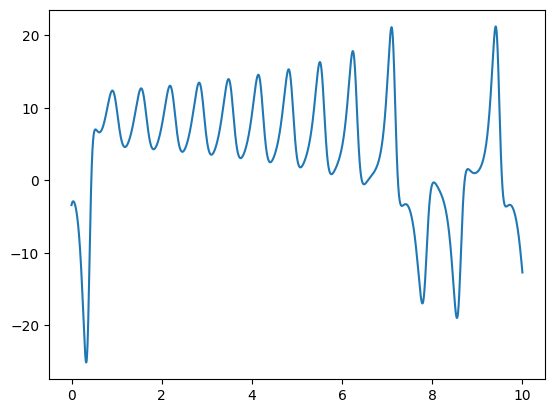

In [140]:
plt.plot(tSpan, solJax)

In [141]:
sensAD = jacrev(xt)(par)

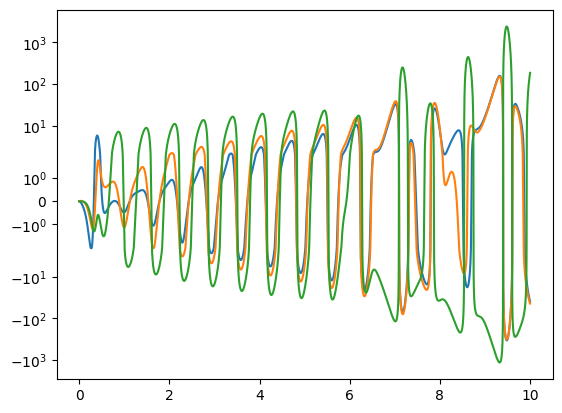

In [142]:
for i in range(3):
    plt.plot(tSpan, sensAD[:,i])
plt.yscale('symlog')

In [143]:
# good old-fashined forward
from numba import njit

In [144]:
x0 = np.array(x0)
par = np.array(par)
tSpan = np.array(tSpan)


In [145]:
stateDim, parDim = len(x0), len(par)

@njit
def F(t,w,par):  
    x,y,z = w
    sigma,rho, beta = par
    dx = sigma*(y-x)
    dy = x*(rho-z)-y
    dz = x*y - beta*z
    return np.array([dx,dy,dz])
        
@njit
def J(t,w,par):  
    x,y,z = w
    sigma,rho, beta = par
    return np.array([[-sigma, sigma, 0.],
                      [rho-z, -1., -x],
                      [y, x, -beta]])

@njit
def dFdtheta_constant(t,w,par):  
    x,y,z = w
    sigma,rho, beta = par
    
    return np.array([[y-x, 0., 0.],
                     [0., x, 0.],
                     [0., 0., -z]])        

@njit
def jointF(t,jointState,par):
    xx = jointState[:stateDim]
    s = jointState[stateDim:].reshape((stateDim,parDim))
    dx = F(t,xx,par)
    ds = (J(t,xx,par).dot(s) + dFdtheta_constant(t,xx,par)).reshape((stateDim*parDim,))
    return np.hstack((dx,ds))
    
jointState = np.zeros(stateDim*(parDim+1))
jointState[:stateDim] = x0[:]
sol_buffer = solve_ivp(fun=lambda t,z: jointF(t,z,par), t_span=(tSpan[0],tSpan[-1]), y0=jointState, t_eval=tSpan, method='LSODA', rtol=tol, atol=tol)


In [146]:
sensF = sol_buffer.y[stateDim:,:].reshape([stateDim, parDim, -1])

In [147]:
for i in range(3):
    plt.plot(tSpan, sensAD[:,i]-sensF[1,i,:])

In [148]:
for i in range(3):
    plt.plot(tSpan, sensF[1,i,:])

plt.yscale('symlog')

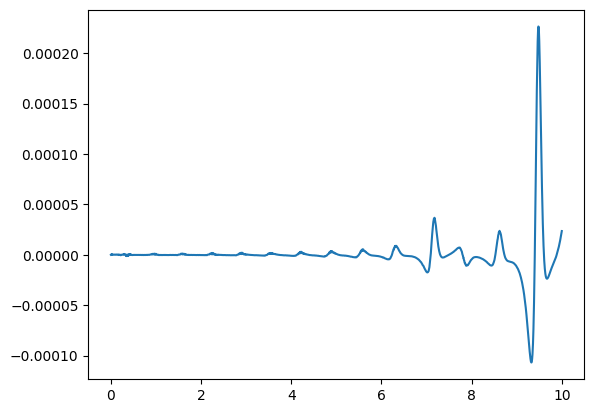

In [149]:
plt.plot(tSpan, solJax-sol_buffer.y[1,:])


In [150]:
sensF_sum = np.sum(sensF, axis=1, keepdims=True)
sensF = sensF/sensF_sum

/tmp/ipykernel_3544293/2483237761.py:2: RuntimeWarning: invalid value encountered in divide
  sensF = sensF/sensF_sum


In [151]:
sensAD_sum = np.sum(sensAD, axis=1, keepdims=True)
sensAD = sensAD/sensAD_sum

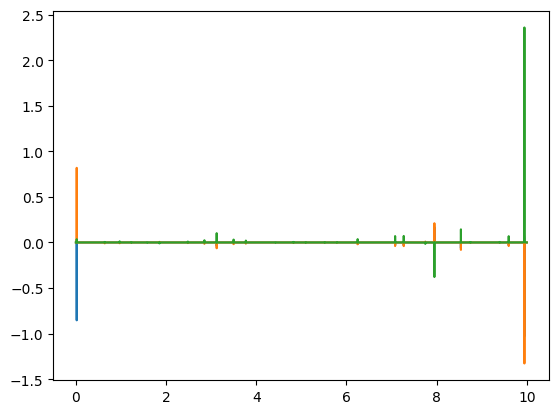

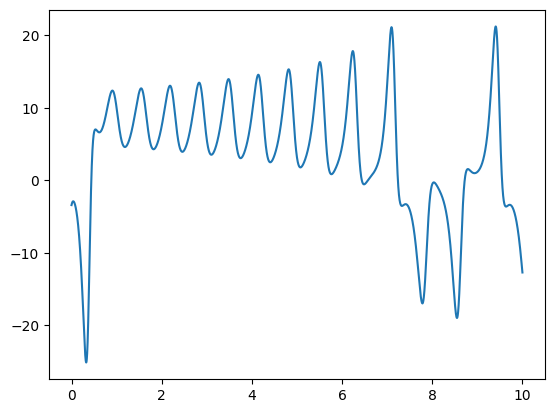

In [152]:
for i in range(3):
    plt.plot(tSpan, sensF[1,i,:]-sensAD[:,i])
plt.figure()
plt.plot(tSpan, sol_buffer.y[1,:])